In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_entry = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
#year_ago
# Perform a query to retrieve the data and precipitation scores
prcp_12_months = session.query(Measurement.station,Measurement.date,Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').all()

# prcp_12_months


In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_12_months, columns = ['station','date','prcp'])
df = df.fillna(0)
df = df.set_index('date')
# Sort the dataframe by date
df = df.sort_values(by='date')

df

,station,prcp
date,,
2016-08-23,USC00519397,0.00
2016-08-23,USC00517948,0.00
2016-08-23,USC00519281,1.79
2016-08-23,USC00514830,0.05
2016-08-23,USC00513117,0.15
...,...,...
2017-08-22,USC00519523,0.00
2017-08-23,USC00514830,0.00
2017-08-23,USC00519397,0.00


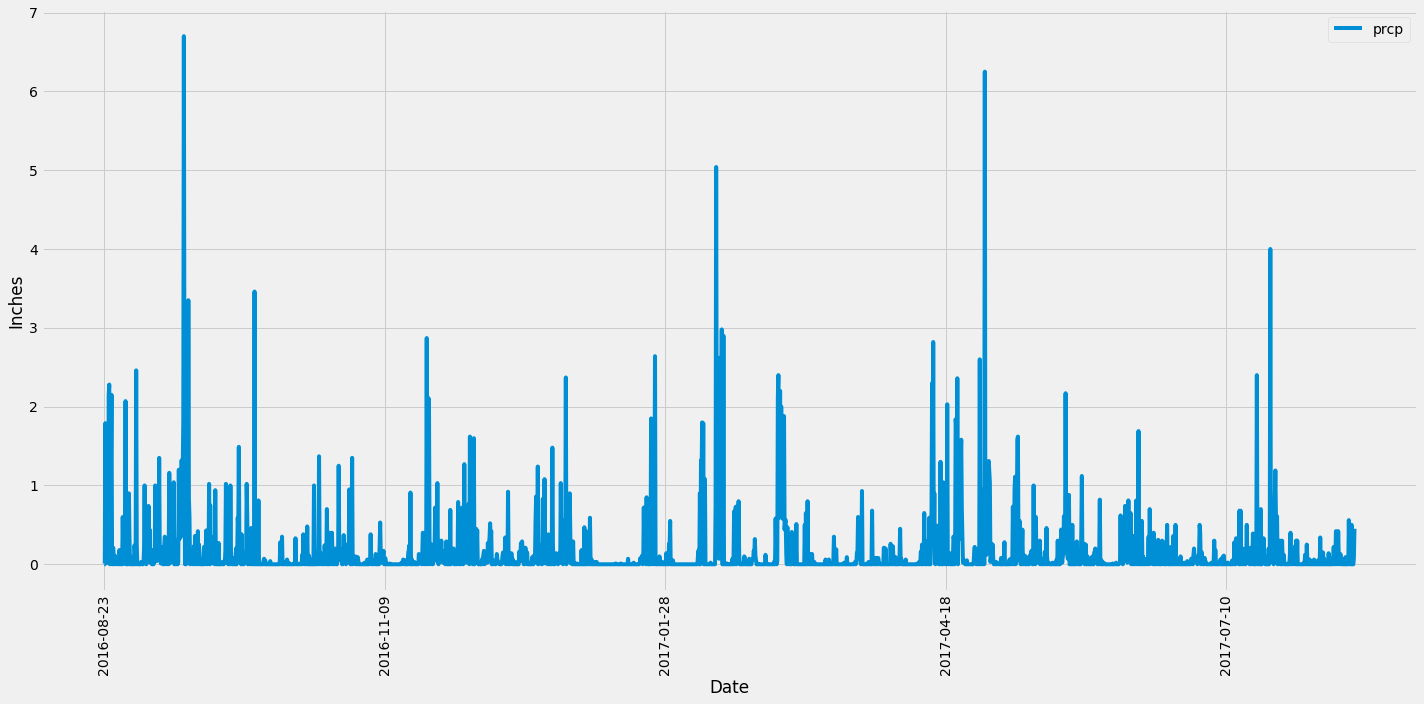

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(rot=90)
plt.gcf().set_size_inches(20, 10)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()

plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe(include='all')

,station,prcp
count,2230,2230.000000
unique,7,NaN
top,USC00519397,NaN
freq,361,NaN
mean,NaN,0.160664
std,NaN,0.442067
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.010000
75%,NaN,0.110000


In [15]:
station_entry = session.query(func.count(Station.station)).all()
station_entry

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

tobs_min_temp = session.query(Measurement.date,func.min(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
# tobs_min_temp

tobs_max_temp = session.query(Measurement.date,func.max(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
# tobs_max_temp

tobs_avg_temp  = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
tobs_avg_temp


[(71.66378066378067)]

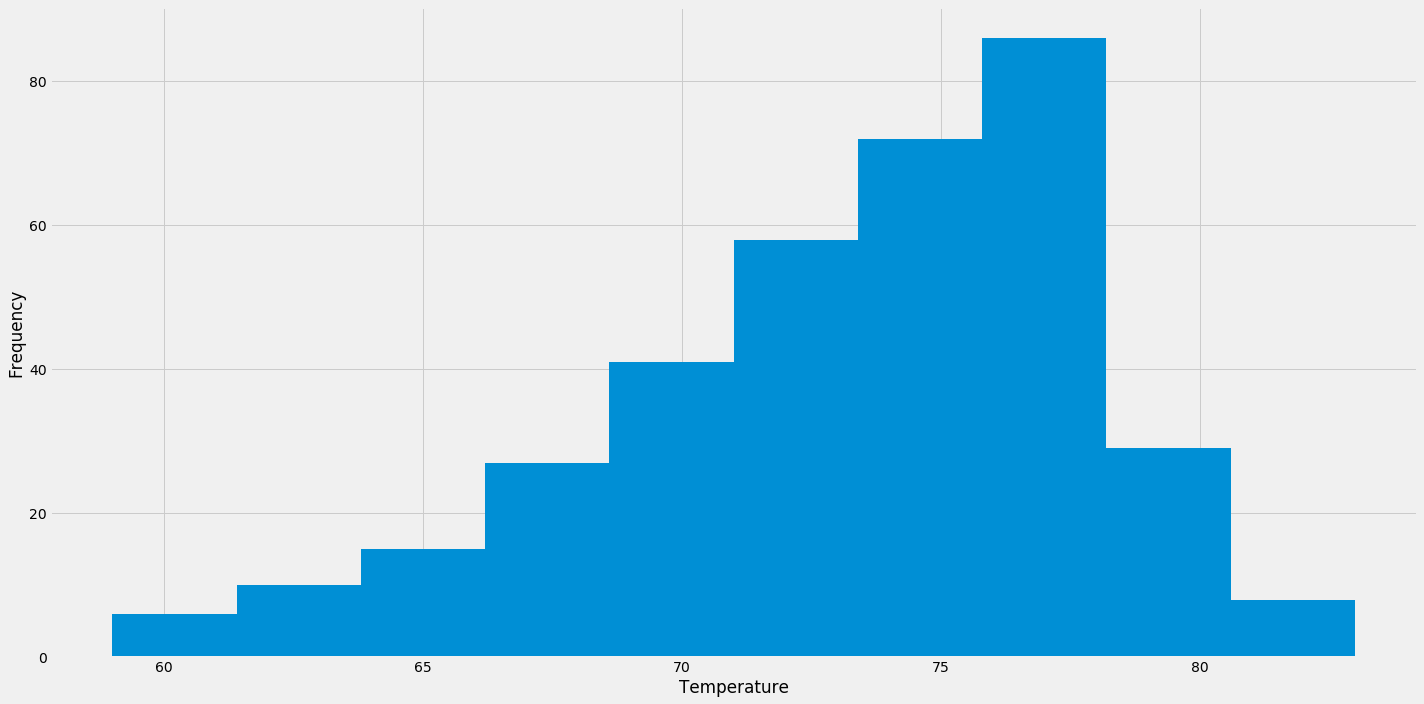

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_12_months = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').\
    filter(Measurement.station=='USC00519281').all()
# tobs_12_months


df2 = pd.DataFrame(tobs_12_months, columns = ['date','tobs'])
df2 = df2.fillna(0)
# df2

plt.hist(df2['tobs'])
plt.gcf().set_size_inches(20, 10)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()

## Bonus Challenge Assignment

In [19]:
###Temperature Analysis I
from datetime import datetime as dt
from sqlalchemy import extract
from scipy.stats import ttest_ind
# selected_month = '06'
# sqlalchemy.extract('month', Measurement.date) == '06'
junesql = session.query(Measurement.date,func.avg(Measurement.tobs)).\
                        filter(extract('month', Measurement.date)=='06',extract('year',Measurement.date)).\
                        group_by(extract('year',Measurement.date),extract('month',Measurement.date)).all()
# junesql

decsql =  session.query(Measurement.date,func.avg(Measurement.tobs)).\
                        filter(extract('month', Measurement.date)=='12',extract('year',Measurement.date)).\
                        group_by(extract('year',Measurement.date),extract('month',Measurement.date)).all()

june_result =[]
for DATE, TOBS in junesql:
    june_dict = {}
    june_dict['DATE'] = DATE
    june_dict['AVG_TEMP'] = TOBS
    june_result.append(june_dict)

dec_result =[]
for DATE, TOBS in decsql:
    dec_dict = {}
    dec_dict['DATE'] = DATE
    dec_dict['AVG_TEMP'] = TOBS
    dec_result.append(dec_dict)
    
june_df = pd.DataFrame(june_result)
dec_df = pd.DataFrame(dec_result)

# dec_df

ttest_sp = ttest_ind(june_df['AVG_TEMP'],dec_df['AVG_TEMP'])
ttest_sp
#the returned p value is "pvalue=9.681543069110451e-06", an extremely small number, therefore the result is statistically significant


Ttest_indResult(statistic=6.97605237788662, pvalue=9.681543069110451e-06)

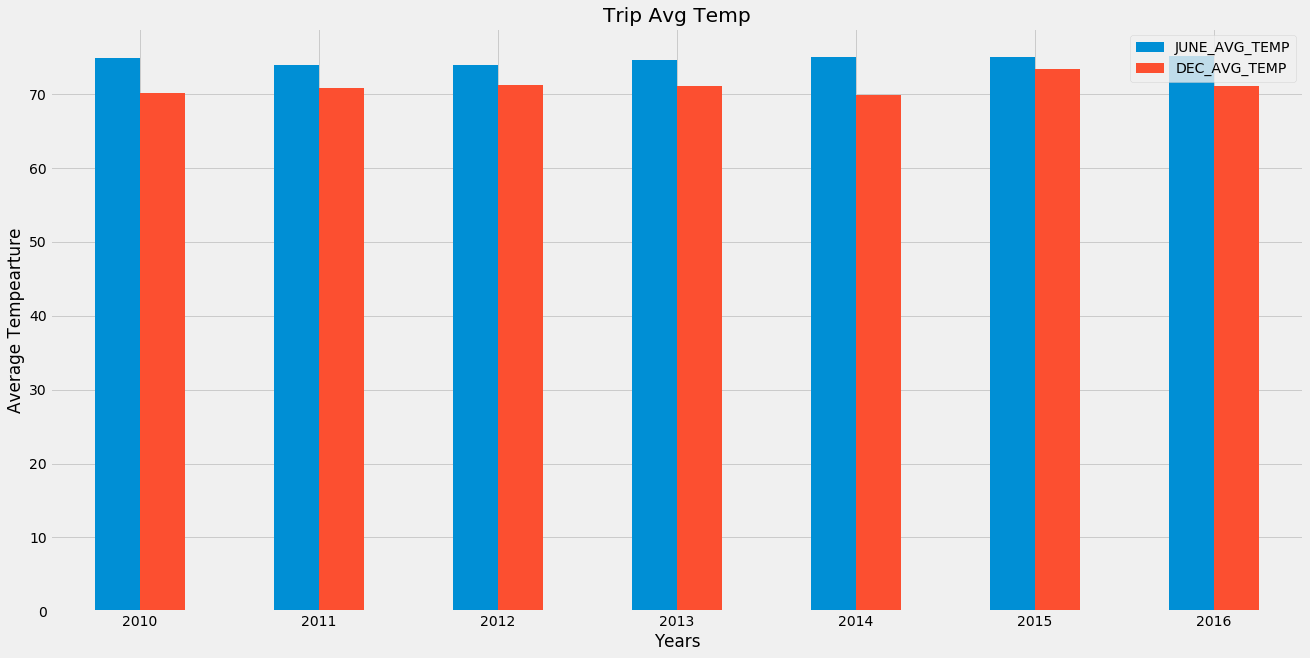

In [20]:
###backup df for plotting
june_date_df =[]
for date_str in june_df['DATE']:
    year, month, day = date_str.split('-')
    date_dict = {}
    date_dict['YEAR'] = year
    date_dict['MONTH'] = month
    date_dict['day'] = day
    june_date_df.append(date_dict)
    
june_date_df = pd.DataFrame(june_date_df)
june_merged = june_date_df.merge(june_df,on=None,right_index=True,left_index=True)
june_merged = june_merged.rename(columns={'AVG_TEMP':'JUNE_AVG_TEMP'})
june_merged = june_merged.drop(columns = ['MONTH','day','DATE'])
# june_merged


dec_date_df =[]
for date_str in dec_df['DATE']:
    year, month, day = date_str.split('-')
    date_dict = {}
    date_dict['YEAR'] = year
    date_dict['MONTH'] = month
    date_dict['day'] = day
    dec_date_df.append(date_dict)
    
dec_date_df = pd.DataFrame(dec_date_df)
dec_merged = dec_date_df.merge(dec_df,on=None,right_index=True,left_index=True)
dec_merged = dec_merged.rename(columns={'AVG_TEMP':'DEC_AVG_TEMP'})
dec_merged = dec_merged.drop(columns = ['MONTH','day','DATE'])
# dec_merged

avgtemp_merged = june_merged.merge(dec_merged,on='YEAR')
avgtemp_merged = avgtemp_merged.set_index(avgtemp_merged['YEAR'])
avgtemp_merged = avgtemp_merged.drop(columns={'YEAR'})
# avgtemp_merged

avgtemp_merged.plot(kind='bar',rot=0)
plt.gcf().set_size_inches(20, 10)
plt.xlabel('Years')
plt.ylabel('Average Tempearture')
plt.title("Trip Avg Temp")

plt.show()

In [21]:
june_merged

,YEAR,JUNE_AVG_TEMP
0,2010,74.925620
1,2011,73.938326
2,2012,74.000000
3,2013,74.599078
4,2014,75.027907
5,2015,74.990148
6,2016,75.175258
7,2017,77.219895


In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
   
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    


# function usage example
# print(calc_temps('2015-01-01', '2017-01-01'))

temp2a_list = []
for TMIN, TAVG, TMAX in calc_temps('2016-01-01', '2017-01-01'):
    temp2a_dict ={}
    temp2a_dict['tmin'] = TMIN
    temp2a_dict['tavg'] = TAVG
    temp2a_dict['tmax'] = TMAX
    temp2a_list.append(temp2a_dict)
# temp2a_list

temp2a_df = pd.DataFrame(temp2a_list)
temp2a_df



,tmin,tavg,tmax
0,56.0,74.131749,84.0


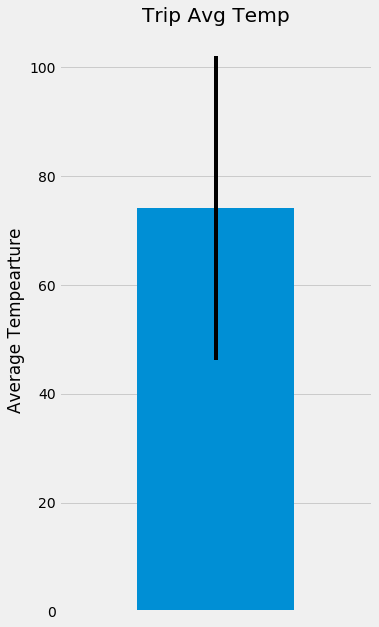

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

diff = ((temp2a_df['tmax']-temp2a_df['tmin']))
diff

temp2a_df['tavg'].plot(kind='bar',rot=0,yerr=diff)
plt.gca().axes.get_xaxis().set_ticks([])
plt.gcf().set_size_inches(5, 10)
plt.ylabel('Average Tempearture')
plt.title("Trip Avg Temp")

plt.show()


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [89]:
### preparing dates

date_range = session.query(Measurement.date).\
                filter(Measurement.station=='USC00519281').filter(Measurement.date>='2016-01-01').filter(Measurement.date<='2016-02-14').all()

# date_range
date_list =[]
for i in date_range:
    date_dict = {}
    date_dict['date'] = i
    date_list.append(date_dict)

#change datatype from object to str
date_df = pd.DataFrame(date_list)
date_df['date'] = date_df['date'].astype(str)

# Stip off the year and save a list of %m-%d strings
#slice into proper %m-%d format
sdate_list = []
for elem in date_df['date']:
    sdate_list.append(elem[7:-3])
# sdate_list



# cdate_df
# cdate_list


#### unused codes for the opposite purposes
####
####
# date_range = session.query(Measurement.date).\
#                 filter(Measurement.station=='USC00519281').filter(Measurement.date>='2016-01-01').filter(Measurement.date<='2016-02-28').all()

# # date_range
# date_list =[]
# for i in date_range:
#     date_list.append(i)
    
# #covert 'result' into 'string'
# df = pd.DataFrame(date_list)
# df['date'] = df['date'].astype(str)

# df['date']
# #convert 'string' into 'datetime' format
# dtlist = [dt.strptime(i,'%Y-%m-%d')for i in df['date']]

# #convert '%Y-%m-%d' into '%m-%d'
# req_format = [dt.strftime(i,"%m-%d") for i in dtlist]
# req_format

# formatted_datelist =[]
# for i in req_format:
#     formatted_datelist.append(i)

# df['date']

,DATE
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05
5,2016-01-06
6,2016-01-07
7,2016-01-08
8,2016-01-09
9,2016-01-10


In [106]:
### test case
###
###
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) ==  date).all()

# for date in formatted_datelist: 
dailynormals_list =[]
for date in sdate_list:
    for TMIN, TAVG, TMAX in daily_normals(date):
        dailynormals_dict = {}
        dailynormals_dict['TMIN'] = TMIN
        dailynormals_dict['TAVG'] = TAVG
        dailynormals_dict['TMAX'] = TMAX
        dailynormals_list.append(dailynormals_dict)
    
df = pd.DataFrame(dailynormals_list)
df

,TMIN,TAVG,TMAX
0,62.0,69.153846,77.0
1,60.0,69.396226,77.0
2,62.0,68.909091,77.0
3,58.0,70.000000,76.0
4,56.0,67.964286,76.0
5,61.0,68.964912,76.0
6,57.0,68.543860,76.0
7,57.0,67.160714,75.0
8,58.0,67.929825,78.0
9,62.0,69.741379,77.0


In [104]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
cdate_list = []
for elem in date_df['date']:
    cdate_list.append(elem[2:-3])
    
cdate_df = pd.DataFrame(cdate_list)
cdate_df = cdate_df.rename(columns={0:'DATE'})

merged_date_df = df.merge(cdate_df, on=None,right_index=True,left_index=True)
merged_date_df = merged_date_df.set_index('DATE')
# merged_date_df


Text(0.5, 0, 'Date')

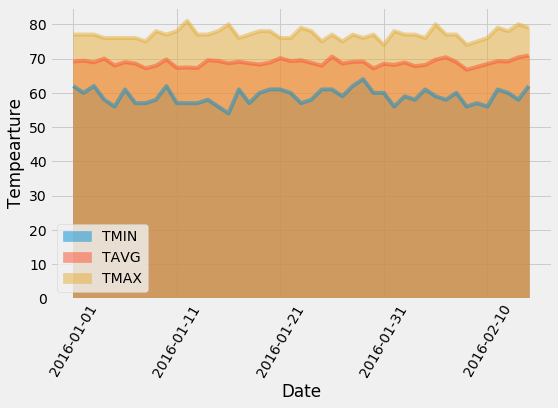

In [105]:
# Plot the daily normals as an area plot with `stacked=False`
ax = merged_date_df.plot.area(stacked=False, rot=60)
plt.gcf().set_size_inches(8, 5)
plt.ylabel('Tempearture')
plt.xlabel('Date')